# Importación de Bibliotecas

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder

# Carga de datos y Preprocesamiento

Importamos el dataset de entrenamiento

In [2]:
df = pd.read_csv("./train_normalizado_lematizacion.csv")

ds_trabajo = df.copy()
ds_trabajo.head(5)

,ID,review_es,sentimiento
0,0,uno de el otro crítico haber mencionar que des...,positivo
1,1,uno pequeño pequeño producción el técnica de f...,positivo
2,2,pensar que este ser uno manera maravilloso de ...,positivo
3,3,básicamente haber uno familia donde uno niño...,negativo
4,4,el amor en el tiempo de petter mattei ser ...,positivo


Creamos una función para mostrar las métricas y la matriz de confusión de nuestras predicciones.

In [3]:
def mostrar_metricas(y_test, y_pred):
    print("La accuracy es {}".format(accuracy_score(y_test, y_pred)))
    print("La precision es {}".format(precision_score(y_test, y_pred, average='macro')))
    print("El recall es {}".format(recall_score(y_test, y_pred, average='macro')))
    print("El F1 es {}".format(f1_score(y_test, y_pred, average='macro')))

    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Valores Predicción')
    plt.ylabel('Valores Reales')

Obtenemos las stopwords en español de la bibliotecta nltk para eliminarlas de los textos posteriormente.

In [8]:
stopwords = nltk.corpus.stopwords.words('spanish')

Vamos a aplicar las técnicas de lemmatización y stemming para reducir la cantidad y la complejidad de las palabras en los textos, generando dos datasets distintos con estos preprocesamientos para utilizar a lo largo del trabajo. 

Nota: vamos a dejar los preprocesamientos aplicados comentados y los guardaremos en los csv `train_normalizado_lematizacion.csv` y `train_normalizado_stemming.csv`. Vamos a hacer lo mismo para `test.csv`.

In [20]:
## Aplicamos lemmatizacion
# import re
# ds_trabajo.review_es = ds_trabajo.review_es.str.lower();
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
# ds_trabajo.review_es

In [21]:
# nlp = spacy.load('es_core_news_sm')

# # Realizar la lematización en la columna 'Texto'
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

# print(ds_trabajo.review_es)

In [22]:
## Aplicamos stemming
# from nltk.stem import SnowballStemmer

# stemmer = SnowballStemmer('spanish')

# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# print(ds_trabajo.review_es)

Dividimos el dataset usando train-test split 80/20.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

Y observamos que los conjuntos luego del split quedaron balanceados.

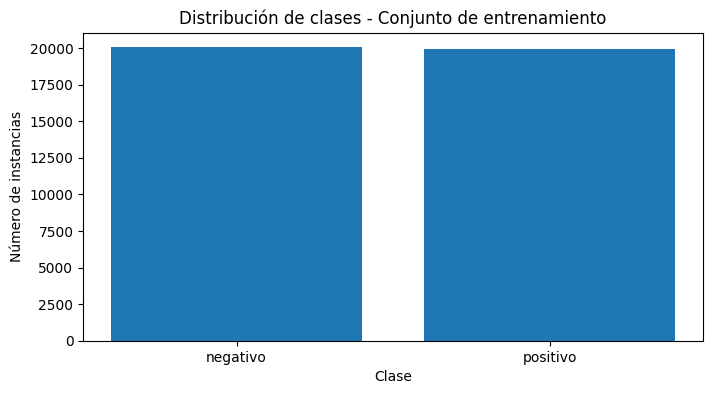

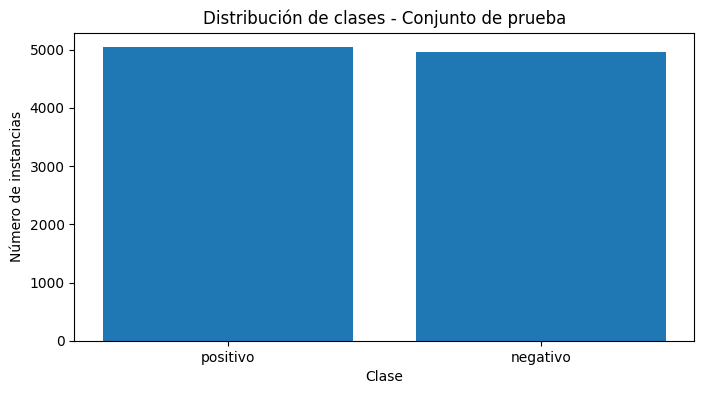

In [5]:
import matplotlib.pyplot as plt

train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

# Visualización del conjunto de entrenamiento
plt.figure(figsize=(8, 4))
plt.bar(train_class_counts.index, train_class_counts.values)
plt.title('Distribución de clases - Conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

# Visualización del conjunto de prueba
plt.figure(figsize=(8, 4))
plt.bar(test_class_counts.index, test_class_counts.values)
plt.title('Distribución de clases - Conjunto de prueba')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

Por último, vamos a trabajar con las etiquetas de sentimiento, 'negativo' y 'positivo', como 0 y 1 para realizar los entrenamientos y las predicciones.

In [6]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Bayes Naïve

## Modelo 1: Bayes Naïve con CountVectorizer

Como primer modelo vamos a probar Bayes Naïve tokenizando con CountVectorizer y eliminando las stopwords. Usaremos un clasificador multinomial y técnica de Laplace Smoothing con alpha = 1.

In [29]:
modelo = make_pipeline(CountVectorizer(stop_words=stopwords, ngram_range=(1,3)), MultinomialNB(alpha=1))
modelo.fit(X_train, y_train_encoded)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('multinomialnb', MultinomialNB(alpha=1))])

Observamos que las métricas dan todas similares, cercanas al 88%.

La accuracy es 0.8805
La precision es 0.8811218585987137
El recall es 0.8806619994760481
El F1 es 0.8804769069431906


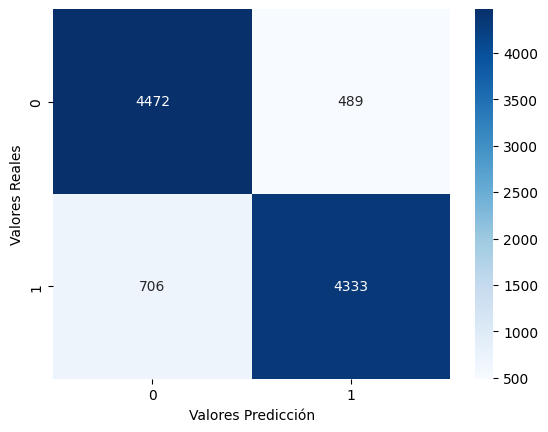

In [30]:
y_pred_encoded = modelo.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

## Modelo 2: Bayes Naïve con TfidfVectorizer

Vamos a entrenar un segundo modelo Bayes Naïve, esta vez utilizando valores normalizados, computando la frecuencia inversa de cada término con TfidfVectorizer.

In [31]:
modelo_2 = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3)), MultinomialNB(alpha=1))

modelo_2.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('multinomialnb', MultinomialNB(alpha=1))])

Observando las métricas, estas dieron un poco más bajas que con CountVectorizer, pero cercanas igualmente al 88%.

La accuracy es 0.878
La precision es 0.8781962537270845
El recall es 0.8780939832379402
El F1 es 0.8779967010307957


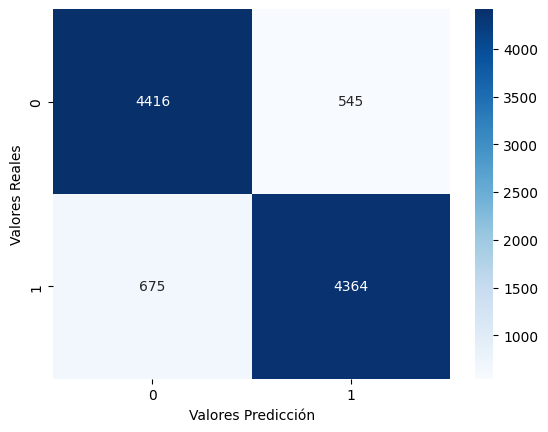

In [32]:
y_pred_encoded = modelo_2.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

## Optimización de hiperparámetros

Vamos a buscar optimizar hiperparámetros para los modelos Bayes Naïve con CountVectorizer y con TfidfVectorizer.

Ajustaremos el parámetro de suavizado aditivo (alpha), el fit prior y el rango de n-grama a aplicar. Vamos a usar las etiquetas codificadas numéricamente, usando el y_train_encoded, optimizando primero para la codificación con TfidfVectorizer.

In [11]:
parametros = {
    'multinomialnb__alpha': np.arange(0, 1.2, 0.2),
    'multinomialnb__fit_prior': [True, False],
    'tfidfvectorizer__ngram_range': [(1, 2), (1, 3)]
}

pipeline = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3)), MultinomialNB(force_alpha=True))

random_search = RandomizedSearchCV(pipeline, parametros, scoring='f1', cv=5, n_iter=5)
random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo = random_search.best_estimator_

print(f"Mejores parametros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")

C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by z

Mejores parametros: {'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__fit_prior': True, 'multinomialnb__alpha': 0.2}
Mejor puntaje: 0.8807425342161377


Entrenamos el mejor modelo obtenido, el cual presenta los siguientes hiperparámetros:
ngram_range de (1, 3), fit_prior en False y alpha de 0.2.

In [12]:
mejor_modelo.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('multinomialnb', MultinomialNB(alpha=0.2, force_alpha=True))])

Realizamos las predicciones y analizamos sus métricas. Podemos ver que, tras la optimización de hiperparámetros, conservamos métricas similares a las obtenidas originalmente, todas cercanas a 88.69%.

La accuracy es 0.8869
La precision es 0.886977697769777
El recall es 0.886962542801104
El F1 es 0.8868998631488344


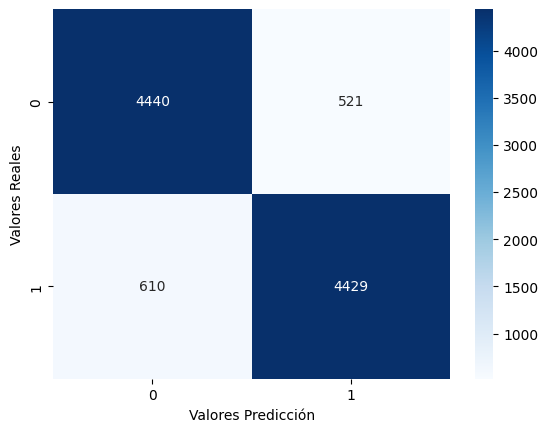

In [13]:
y_pred_encoded = mejor_modelo.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

Ahora probaremos optimizar hiperparámetros para la codificación con CountVectorizer.

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

parametros = {
    'multinomialnb__alpha': np.arange(0, 1.2, 0.2),
    'multinomialnb__fit_prior': [True, False],
    'countvectorizer__ngram_range': [(1, 2), (1, 3)]
}

pipeline = make_pipeline(CountVectorizer(stop_words=stopwords, ngram_range=(1,3)), MultinomialNB())

random_search = RandomizedSearchCV(pipeline, parametros, scoring='f1', cv=5, n_iter=5)
random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo = random_search.best_estimator_

print(f"Mejores parametros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")


C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10.

Mejores parametros: {'multinomialnb__fit_prior': False, 'multinomialnb__alpha': 0.6000000000000001, 'countvectorizer__ngram_range': (1, 3)}
Mejor puntaje: 0.8686147563957196


Los mejores hiperparámetros obtenidos para CountVectorizer son similares a los anteriores, pero con alpha 0.6.

In [41]:
mejor_modelo.fit(X_train, y_train_encoded)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('multinomialnb',
                 MultinomialNB(alpha=0.6000000000000001, fit_prior=False))])

De nuevo, las métricas son similres a las obtenidas originalmente. Sin embargo, esta vez son ligeramente menores que las métricas con la tokenización TfidfVectorizer.

La accuracy es 0.8799
La precision es 0.8805335715086753
El recall es 0.8800635230647432
El F1 es 0.8798761181710535


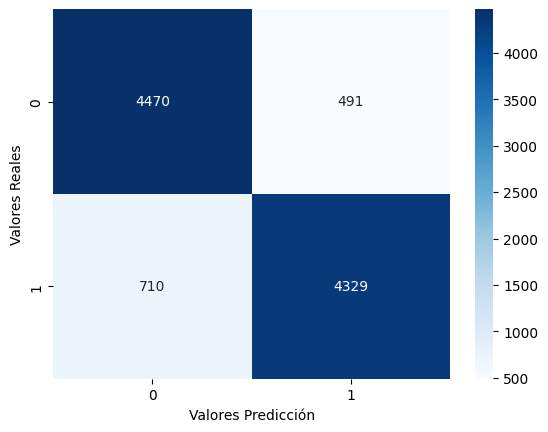

In [42]:
y_pred_encoded = mejor_modelo.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

Para Bayes Naïve, no obtuvimos cambios significativos tras la optimización de hiperparámetros, para ninguno de los tres datasets de entrenamiento preprocesados.

# Random Forest

Empezamos creando un modelo Random Forest por default, eliminando stopwords y usando ngram entre 1 y 3 y observamos las métricas obtenidas.

In [43]:
modelo_rf = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3)), RandomForestClassifier())

modelo_rf.fit(X_train, y_train_encoded)

Tenemos métricas similares en todos los casos.

La accuracy es 0.8526
La precision es 0.8526173362564071
El recall es 0.8526347142960178
El F1 es 0.8525992865805472


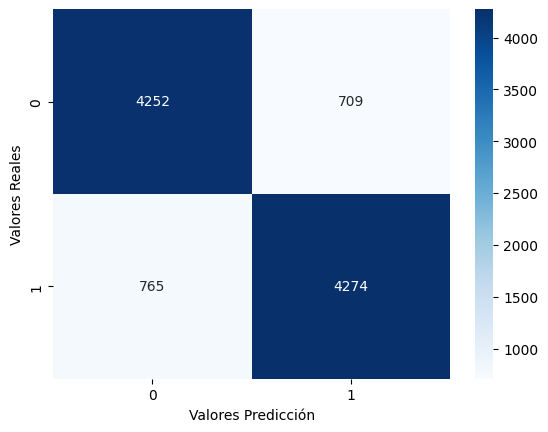

In [ ]:
y_pred_encoded = modelo_rf.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred.astype)

## Optimización de hiperparámetros

Aplicamos Random Search para buscar los mejores hiperparámetros de un modelo Random Forest.

(Nota: vamos a estar realizando iteraciones de RandomSearch para obtener hiperparámetros optimizados, intentando con Grid Search tardó demasiado y no logramos terminar de correrlo).

In [14]:
parametros = {
    'randomforestclassifier__n_estimators': [130, 150, 200, 300],
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, 30, 35],
    'randomforestclassifier__min_samples_split': [5, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
}

pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3)),
    RandomForestClassifier()
)

random_search = RandomizedSearchCV(
    pipeline,
    parametros,
    scoring='f1',
    n_iter=15,
    cv=6,
    random_state=42
)

random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo = random_search.best_estimator_

print(f"Mejores parametros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")

Mejores parametros: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__criterion': 'entropy'}
Mejor puntaje: 0.8507545687231283


In [15]:
mejor_modelo.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=35,
                                        min_samples_split=20,
                                        n_estimators=300))])

Analizamos las métricas del mejor modelo obtenido en esta iteración.

La accuracy es 0.8531
La precision es 0.8534090565018482
El recall es 0.8529826354635417
El F1 es 0.8530307936704316


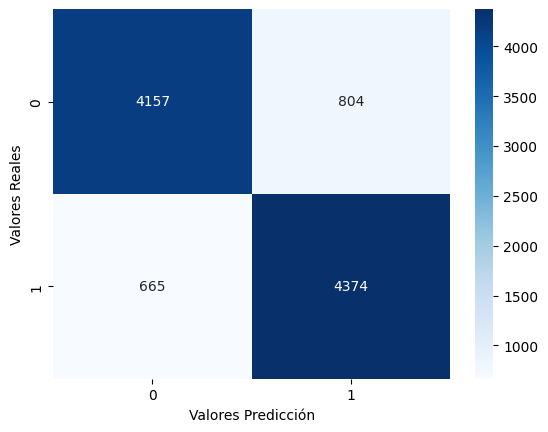

In [16]:
y_pred_encoded = mejor_modelo.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

**NOTA sobre la mejor submission hasta el momento que hicimos en kaggle:**
La mejor que obtuvimos con random search: 83% aprox. todo en entrenamiento, 73% en test con el dataset original y con 
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__criterion': 'entropy'}

Estas son las metricas de ese modelo en train, es el que es 0.7377 en kaggle:
La accuracy es 0.8398
La precision es 0.8413158539503673
El recall es 0.8395375174625624
El F1 es 0.8395406913388312

# XGBoost


Utilizamos LabelEncoder para convertir y_train e y_test en un vector numerico, siendo 0 equivalente a negativo y 1 a positivo, y asi poder hacer un modelo XGBoost

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_train_tranf= label_encoder.fit_transform(y_train)
y_test_tranf= label_encoder.fit_transform(y_test)



In [ ]:
modelo_xgb = make_pipeline(TfidfVectorizer(stop_words=stopwords), xgb.XGBClassifier())

modelo_xgb.fit(X_train, y_train_tranf)

y_pred = modelo_xgb.predict(X_test)

La accuracy es 0.8378
La precision es 0.8382279453953125
El recall es 0.8376575230837044
El F1 es 0.8377001791181649


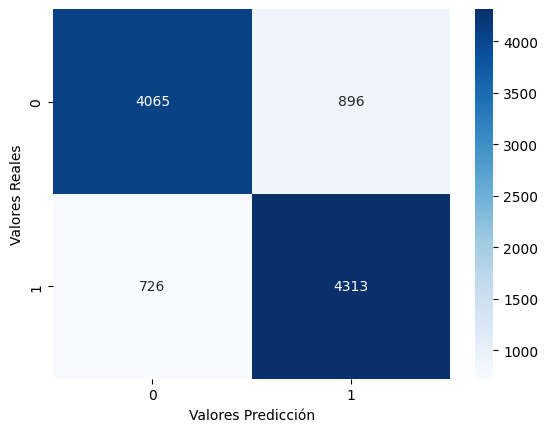

In [ ]:
mostrar_metricas(y_test_tranf, y_pred)

Transformo los 0 y 1 en negativo y positivo respectivamente.

In [ ]:
y_pred_xgb_tranf = label_encoder.inverse_transform(y_pred)

## Optimización de hiperparámetros

Aplicamos Random Search para buscar los mejores hiperparámetros de un modelo XGBoost Classifier.

In [ ]:
params = {
    'xgbclassifier__learning_rate':    [0.05, 0.3],
    'xgbclassifier__max_depth':        [5, 16, 5], 
    'xgbclassifier__min_child_weight': [1, 10, 1], 
    'xgbclassifier__colsample_bytree': [0.3, 1], 
    'xgbclassifier__subsample':        [0.4, 1], 
    'xgbclassifier__n_estimators':     [5, 10, 15, 20],
    'xgbclassifier__reg_alpha':        [0, 0.001, 0.005, 0.01, 0.05], 
    'xgbclassifier__gamma':            [0, 0.005, 0.01, 0.05, 1]
}
pipeline= make_pipeline(TfidfVectorizer(stop_words=stopwords), xgb.XGBClassifier())
random_search=   RandomizedSearchCV(pipeline, params,scoring="f1",cv=5)
random_search.fit(X_train, y_train_tranf)


#Obtenemos el mejor modelo y los mejores parámetros
mejor_modelo_xgb_cv = random_search.best_estimator_
mejores_parametros_xgb_cv = random_search.best_params_

In [ ]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_xgb_cv = mejor_modelo_xgb_cv.predict(X_test)

Analizamos las métricas del mejor modelo obtenido.

La accuracy es 0.8
La precision es 0.8009216376686781
El recall es 0.799775658351054
El F1 es 0.799754699506896


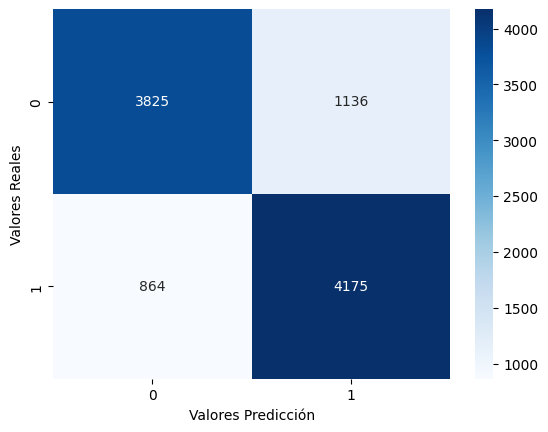

In [ ]:
mostrar_metricas(y_test_tranf, y_pred_xgb_cv)

Obtenemos la mejor combinación de hiperparámetros lograda.

In [ ]:
mejores_parametros_xgb_cv

{'xgbclassifier__subsample': 1,
 'xgbclassifier__reg_alpha': 0.005,
 'xgbclassifier__n_estimators': 20,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__max_depth': 16,
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__gamma': 0.05,
 'xgbclassifier__colsample_bytree': 0.3}

Transformo los 0 y 1 en negativo y positivo respectivamente.

In [ ]:

y_pred_xgb_cv_tranf = label_encoder.inverse_transform(y_pred_xgb_cv)


Conseguimos mejores resultados con el modelo xgboost sin optimizar los parametros. Los resultados obtenidos fueron una precision de 0.84 y un F1 de 0.84

In [ ]:
import pickle

with open('./models/xgboost/xgb_model_1.pickle', 'wb') as archivo:
    pickle.dump(modelo_xgb, archivo)

In [ ]:
"""
Falta corregir esto para armar el csv
with open('./models/xgboost/xgb_model_1.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test_normalizado_lematizacion.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/xgboost/xgb_model_1.csv', index=False)

"""

"\nFalta corregir esto para armar el csv\nwith open('./models/xgboost/xgb_model_1.pickle', 'rb') as archivo:\n    modelo_cargado = pickle.load(archivo)\n\nds_test = pd.read_csv('./test_normalizado_lematizacion.csv')\nds_submission = ds_test.copy()\n\nnuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)\npredicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)\n\ndf_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})\ndf_submission.head()\ndf_submission.to_csv('submissions/xgboost/xgb_model_1.csv', index=False)\n\n"

# Para las predicciones (borrar para la entrega)

In [23]:
import pickle

with open('./models/ensemble/ensemble_model_3.pickle', 'wb') as archivo:
    pickle.dump(mejor_modelo, archivo)

In [24]:
import pickle
from sklearn.preprocessing import LabelEncoder

with open('./models/ensemble/ensemble_model_3.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test_normalizado_lematizacion.csv')
ds_submission = ds_test.copy()

encoder = LabelEncoder()

encoder.fit(y_train)

predicciones_nuevas = modelo_cargado.predict(ds_submission.review_es)

y_predicted = encoder.inverse_transform(predicciones_nuevas)

print(y_predicted)
print(predicciones_nuevas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': y_predicted})
df_submission.head()
df_submission.to_csv('submissions/ensemble/ensemble_submission_3.csv', index=False)

['negativo' 'positivo' 'positivo' ... 'positivo' 'negativo' 'negativo']
[0 1 1 ... 1 0 0]


# Ensambles

## Ensamble voting

Este de abajo ya lo corri en colab

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# import xgboost as xgb
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import f1_score

# parametros_ensamble = {
#     'votingclassifier__modelo1__alpha': [0.1, 0.5, 1],
#     'votingclassifier__modelo2__C': [0.1, 1, 10],
#     'votingclassifier__modelo3__learning_rate': [0.05, 0.1],
#     'votingclassifier__modelo3__max_depth': [5, 10, 15],
#     'votingclassifier__modelo3__n_estimators': [5, 10, 20],
#     'votingclassifier__modelo3__reg_alpha': [0.001, 0.005, 0.01, 0.05],
# }

# modelo1 = MultinomialNB()
# modelo2 = LogisticRegression()
# modelo3 = xgb.XGBClassifier()

# ensamble = VotingClassifier(estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)], voting='hard')

# pipeline = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
#                          ensamble)

# random_search = RandomizedSearchCV(pipeline, parametros_ensamble, scoring='f1', n_iter=5, cv=5, random_state=42)
# random_search.fit(X_train, y_train_encoded)

# mejores_parametros = random_search.best_params_
# mejor_puntaje = random_search.best_score_
# mejor_modelo_ensamble5 = random_search.best_estimator_

# print(f"Mejores parametros: {mejores_parametros}")
# print(f"Mejor puntaje: {mejor_puntaje}")

Mejores parametros: {'votingclassifier__modelo3__reg_alpha': 0.01, 'votingclassifier__modelo3__n_estimators': 20, 'votingclassifier__modelo3__max_depth': 15, 'votingclassifier__modelo3__learning_rate': 0.05, 'votingclassifier__modelo2__C': 1, 'votingclassifier__modelo1__alpha': 0.1}
Mejor puntaje: 0.8821474623717969

In [ ]:
# # Entrenar el ensamble de modelos
# mejor_modelo_ensamble5.fit(X_train, y_train_encoded)

In [ ]:
# y_pred_encoded = mejor_modelo_ensamble5.predict(X_test)
# y_pred = encoder.inverse_transform(y_pred_encoded)
# mostrar_metricas(y_test, y_pred)

La accuracy es 0.8866
La precision es 0.8871719461483689
El recall es 0.8864526917817681
El F1 es 0.8865244661456451

=> 7354 kaggle

Este de abajo ya lo corri en colab

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# import xgboost as xgb
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import f1_score

# parametros_ensamble = {
#     'votingclassifier__modelo1__alpha': [0.1, 0.5, 1],
#     'votingclassifier__modelo2__n_estimators': [150, 200, 300],
#     'votingclassifier__modelo2__max_depth': [5, 15, 25, 35],
#     'votingclassifier__modelo2__min_samples_leaf': [1, 3, 5],
#     'votingclassifier__modelo2__criterion': ['gini', 'entropy'],
#     'votingclassifier__modelo3__learning_rate': [0.05, 0.1],
#     'votingclassifier__modelo3__max_depth': [5, 10, 15],
#     'votingclassifier__modelo3__n_estimators': [5, 10, 20],
#     'votingclassifier__modelo3__reg_alpha': [0.001, 0.005, 0.01, 0.05],
# }

# modelo1 = MultinomialNB()
# modelo2 = RandomForestClassifier()
# modelo3 = xgb.XGBClassifier()

# ensamble = VotingClassifier(estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)], voting='hard')

# pipeline = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
#                          ensamble)

# random_search = RandomizedSearchCV(pipeline, parametros_ensamble, scoring='f1', n_iter=5, cv=5, random_state=42)
# random_search.fit(X_train, y_train_encoded)

# mejores_parametros = random_search.best_params_
# mejor_puntaje = random_search.best_score_
# mejor_modelo_ensamble6 = random_search.best_estimator_

# print(f"Mejores parametros: {mejores_parametros}")
# print(f"Mejor puntaje: {mejor_puntaje}")

In [ ]:
# # Entrenar el ensamble de modelos
# mejor_modelo_ensamble6.fit(X_train, y_train_encoded)

In [ ]:
# y_pred_encoded = mejor_modelo_ensamble6.predict(X_test)
# y_pred = encoder.inverse_transform(y_pred_encoded)
# mostrar_metricas(y_test, y_pred)

## Ensamble stacking

Empezamos por entrenar un modelo de ensamble híbrido Stacking compuesto por una SVM Lineal, un Random Forest y un Bayes Naive como modelos base, y usando Regresión Logística como estimador final, sin optimizar hiperparámetros.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Crear los modelos base
modelo1 = LinearSVC()
modelo2 = RandomForestClassifier()
modelo3 = MultinomialNB()

# Crear el ensamble híbrido de stacking
ensamble = StackingClassifier(
    estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)],
    final_estimator=LogisticRegression()
)

# Crear el pipeline con el TfidfVectorizer y el ensamble
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
    ensamble
)

# Ajustar el ensamble en el conjunto de entrenamiento
pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('modelo1', LinearSVC()),
                                                ('modelo2',
                                                 RandomForestClassifier()),
                                                ('modelo3', MultinomialNB())],
                                    final_estimator=LogisticRegression()))])

La accuracy es 0.9033
La precision es 0.903445035036059
El recall es 0.9032293724750213
El F1 es 0.9032749278940594


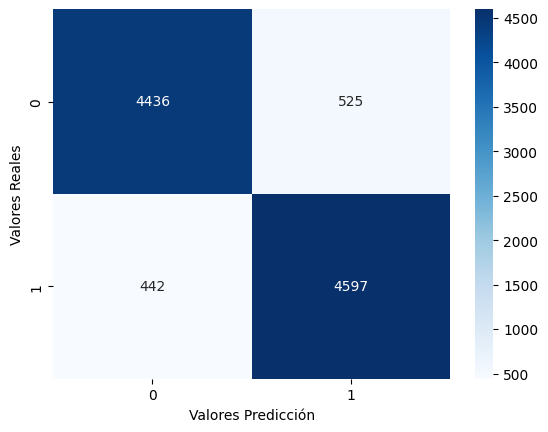

In [ ]:
y_pred_encoded = pipeline.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

Obtuvimos un score de, aproximadamente, 90% en train y 74.16% en test con este modelo. Nuestra mejor submission hasta el momento.

### Optimización de hiperparámetros

Vamos a optimizar hiperparámetros para mejorar la mejor métrica anterior.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

parametros_ensamble = {
    'stackingclassifier__modelo1__C': [0.2, 0.5, 1],
    'stackingclassifier__modelo2__n_estimators': [100, 200, 300],
    'stackingclassifier__modelo2__max_depth': [5, 10, 15],
    'stackingclassifier__modelo3__alpha': [0.1, 0.5, 1],
    'stackingclassifier__final_estimator__C': [0.1, 1, 10]
}

# Modelos base
modelo1 = LinearSVC()
modelo2 = RandomForestClassifier()
modelo3 = MultinomialNB()

# Meta Modelo
meta_model = LogisticRegression(max_iter=500)

ensamble = StackingClassifier(estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)],
                              final_estimator=meta_model,
                              cv=5)


pipeline = make_pipeline(TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
                         ensamble)


random_search = RandomizedSearchCV(pipeline, parametros_ensamble, scoring='f1', n_iter=3, cv=5, random_state=42)
random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo_stacking1 = random_search.best_estimator_

print(f"Mejores parametros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")

Mejores parametros: {'stackingclassifier__modelo3__alpha': 1, 'stackingclassifier__modelo2__n_estimators': 300, 'stackingclassifier__modelo2__max_depth': 10, 'stackingclassifier__modelo1__C': 1, 'stackingclassifier__final_estimator__C': 1}
Mejor puntaje: 0.895817419399755


In [ ]:
# Ajustar el ensamble en el conjunto de entrenamiento
mejor_modelo_stacking1.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('stackingclassifier',
                 StackingClassifier(cv=5,
                                    estimators=[('modelo1', LinearSVC(C=1)),
                                                ('modelo2',
                                                 RandomForestClassifier(max_depth=10,
                                                                        n_estimators=300)),
                                                ('modelo3',
                                                 MultinomialNB(alpha=1))],
                                    final_estimator=LogisticRegression(C=1,
                                                                       max_iter=500)))])

Obtuvimos, aproximadamente, 90.16% en entrenamiento y 74.239% en test, siendo este el nuevo mejor modelo obtenido:

Mejores parametros: {'stackingclassifier__modelo3__alpha': 1, 'stackingclassifier__modelo2__n_estimators': 300, 'stackingclassifier__modelo2__max_depth': 10, 'stackingclassifier__modelo1__C': 1, 'stackingclassifier__final_estimator__C': 1}
Mejor puntaje: 0.895817419399755 (0.9016757640590829 F1)
=> es el stacking hp3

La accuracy es 0.9017
La precision es 0.9018317642193996
El recall es 0.901632395314931
El F1 es 0.9016757640590829


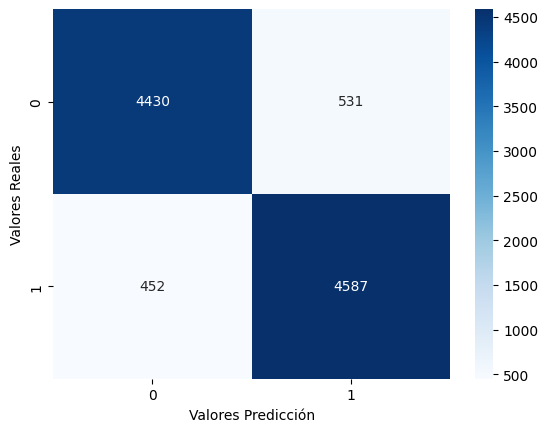

In [ ]:
y_pred_encoded = mejor_modelo_stacking1.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

Probamos un ensamble distinto por default (mover por fuera de optimizacion)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# Crear los modelos base
modelo1 = DecisionTreeClassifier()
modelo2 = LogisticRegression(max_iter=500)
modelo3 = MultinomialNB()

# Crear el ensamble híbrido de stacking
ensamble = StackingClassifier(
    estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)],
    final_estimator=LogisticRegression(max_iter=500)
)

# Crear el pipeline con el TfidfVectorizer y el ensamble
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
    ensamble
)

# Ajustar el ensamble en el conjunto de entrenamiento
pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('modelo1',
                                                 DecisionTreeClassifier()),
                                                ('modelo2',
                                                 LogisticRegression(max_iter=500)),
                                                ('modelo3', MultinomialNB())],
                                    final_estimator=LogisticRegression(max_iter=500)))])

La accuracy es 0.8868
La precision es 0.8869836718614867
El recall es 0.8867166678420715
El F1 es 0.8867649243029521


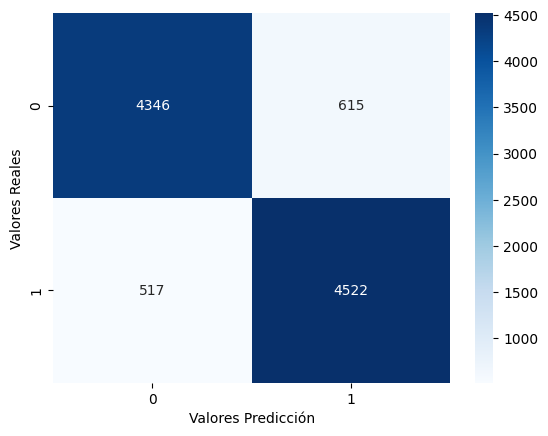

In [ ]:
y_pred_encoded = pipeline.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

Y optimizamos hiperparametros

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelos base
modelo1 = DecisionTreeClassifier()
modelo2 = LogisticRegression(max_iter=500)
modelo3 = LinearSVC()

# Meta modelo
meta_model = LogisticRegression(max_iter=500)

# Crear el ensamble de stacking
ensamble = StackingClassifier(
    estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)],
    final_estimator=meta_model
)

# Crear el pipeline con el TfidfVectorizer y el ensamble
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
    ensamble
)

# Definir los hiperparámetros para el ensamble
parametros_ensamble = {
    'stackingclassifier__modelo1__criterion': ['gini', 'entropy'],
    'stackingclassifier__modelo1__max_depth': [5, 10, 20],
    'stackingclassifier__modelo2__C': [0.1, 1, 10],
    'stackingclassifier__modelo3__C': [0.1, 1, 10]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(pipeline, parametros_ensamble, scoring='f1', n_iter=5, cv=5, random_state=42)
random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo_stacking = random_search.best_estimator_

print(f"Mejores parámetros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")


In [ ]:
# Ajustar el ensamble en el conjunto de entrenamiento
mejor_modelo_stacking.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('modelo1',
                                                 DecisionTreeClassifier(max_depth=5)),
                                                ('modelo2',
                                                 LogisticRegression(C=1,
                                                                    max_iter=500)),
                                                ('modelo3',
                                                 MultinomialNB(alpha=0.1))],
                                    final_estimator=LinearSVC(C=0.1)))])

La accuracy es 0.8933
La precision es 0.8933993043794513
El recall es 0.8932396847024173
El F1 es 0.8932769382135786


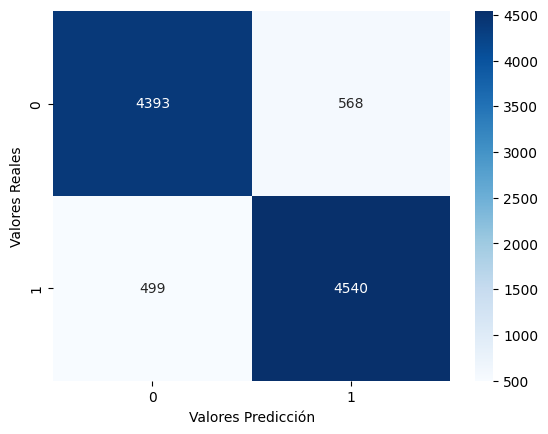

In [ ]:
y_pred_encoded = mejor_modelo_stacking.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)

stacking hp1 es Mejores parámetros: {'stackingclassifier__modelo3__alpha': 0.1, 'stackingclassifier__modelo2__penalty': 'l2', 'stackingclassifier__modelo2__C': 1, 'stackingclassifier__modelo1__max_depth': 5, 'stackingclassifier__modelo1__criterion': 'gini', 'stackingclassifier__final_estimator__C': 0.1}
Mejor puntaje: 0.8904555473245148
con La accuracy es 0.8933
La precision es 0.8933993043794513
El recall es 0.8932396847024173
El F1 es 0.8932769382135786

Y dio 7317 en kaggle

Optimizacion otra de otro modelo

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelos base
modelo1 = DecisionTreeClassifier()
modelo2 = LogisticRegression(max_iter=500)
modelo3 = LinearSVC()

# Meta modelo
meta_model = MultinomialNB()

# Crear el ensamble de stacking
ensamble = StackingClassifier(
    estimators=[('modelo1', modelo1), ('modelo2', modelo2), ('modelo3', modelo3)],
    final_estimator=meta_model
)

# Crear el pipeline con el TfidfVectorizer y el ensamble
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)),
    ensamble
)

# Definir los hiperparámetros para el ensamble
parametros_ensamble = {
    'stackingclassifier__modelo1__criterion': ['gini', 'entropy'],
    'stackingclassifier__modelo1__max_depth': [5, 10, 20],
    'stackingclassifier__modelo2__C': [0.1, 1, 10],
    'stackingclassifier__modelo3__C': [0.1, 1, 10],
    'stackingclassifier__final_estimator__alpha': [0.1, 0.5, 1]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(pipeline, parametros_ensamble, scoring='f1', n_iter=5, cv=5, random_state=42)
random_search.fit(X_train, y_train_encoded)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_
mejor_modelo_stacking = random_search.best_estimator_

print(f"Mejores parámetros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")


In [ ]:
# Entrenar el ensamble de modelos
mejor_modelo_stacking.fit(X_train, y_train_encoded)

In [ ]:
y_pred_encoded = mejor_modelo_stacking.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
mostrar_metricas(y_test, y_pred)